In [1]:
%matplotlib nbagg

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import os
from os import listdir
import re
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('lato_style.mplstyle')

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

In [3]:
def periodic_dmi_x(p1, p2, x):
    xr = x % (p1 + p2)
    
    if xr < p1:
        return 2
    elif xr >= p1 and xr <= (p1 + p2):
        return 1
    else:
        return 0

# Make this function to work element-wise
periodic_dmi_x = np.vectorize(periodic_dmi_x)

# Load Data

In [4]:
mu0 = 4 * np.pi * 1e-7
Ms = 0.658e6

base_folder = '../sim/omfs_w50/'
static_state = '../sim/InitialMagnetisation_w50_ordered.omf'

def key_f(f):
    regex_res = re.search(r'(?<=Magnetization\-)[0-9]+(?=\-)', f).group(0)
    return regex_res

file_list = [_file for _file in listdir(base_folder)
            if _file.startswith('SWDynamics-Oxs_TimeDriver')]
file_list = sorted(file_list, key=key_f)


In [5]:
data0 =  pd.read_csv(static_state, comment='#', header=None, delim_whitespace=True)
data0 = data0.as_matrix()

coordinates = data0[:, :3]

nx = len(np.unique(coordinates[:, 0]))
ny = len(np.unique(coordinates[:, 1]))

mask = coordinates[:, 1] == coordinates[:, 1][nx * int(ny * 0.5)]


In [6]:
 def data_i_state(i):
    data =  pd.read_csv(os.path.join(base_folder, file_list[i]), comment='#',
                        header=None, delim_whitespace=True)
    data = data.as_matrix()
    data[:, 3:] = (data[:, 3:] - data0[:, 3:]) / Ms
    # mz = data[:, 5].reshape(-1, len(np.unique(data[:, 0]))) / Ms
    return data

In [7]:
# data_centre = []
# for i in range(len(file_list)):
#     data = data_i_state(i)
#     data_centre.append(data[:, 4][mask])
# data_centre = np.array(data_centre)
data_centre = np.loadtxt('../sim/datafile_mx_w50.dat')

In [8]:
regions = periodic_dmi_x(50, 50, coordinates[:, 0][mask] * 1e9)

boundaries = []
for i, site in enumerate(regions):
    if i < len(regions) - 1 and regions[i] != regions[i + 1]:
        boundaries.append((coordinates[:, 0][mask] * 1e9)[i])

# Plot

In [9]:
# define the colormap
cmap = plt.cm.Set2
# extract colors from the map
cmaplist = [(cmap(1)[0], cmap(1)[1], cmap(1)[2], 0.3), (1., 1., 1.)]
# create the new map
cmap = matplotlib.colors.ListedColormap(cmaplist, 'Custom cmap', 2)

In [27]:
plt.rcParams['nbagg.transparent'] = False


<IPython.core.display.Javascript object>


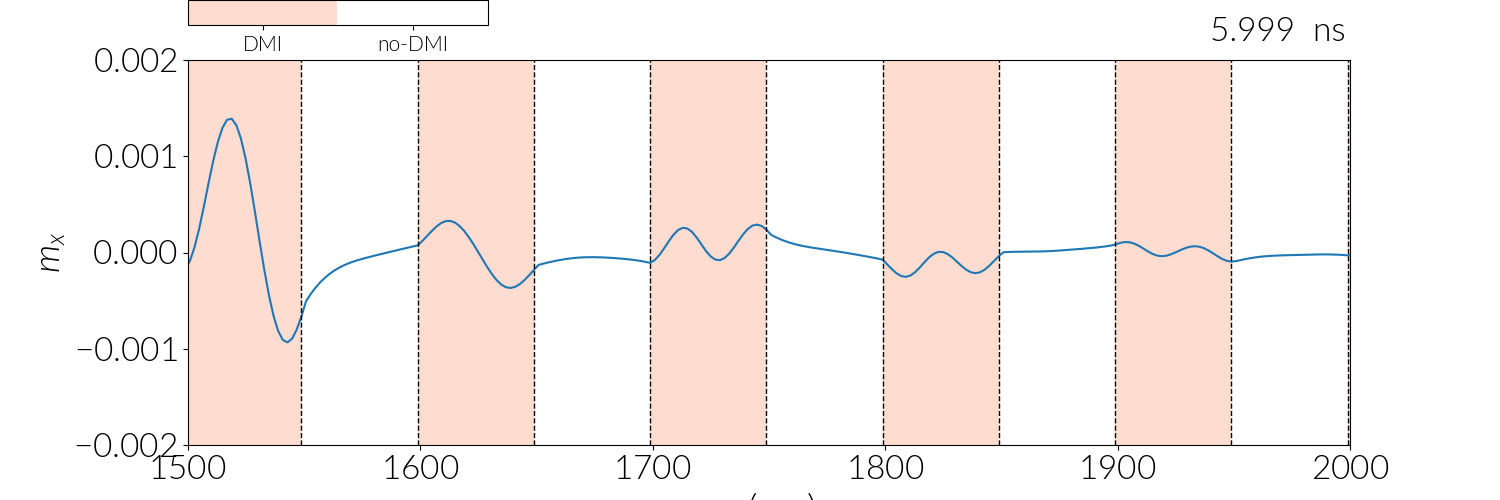

In [28]:
f = plt.figure(figsize=(15, 5), facecolor='w')
ax = f.add_subplot(111)

p, = ax.plot(coordinates[:, 0][mask] * 1e9, data_centre[500])

for i, b in enumerate(boundaries):
    ax.axvline(x=b, ls='--', color='k', lw=1)
    if i < len(boundaries) - 1 and (i + 1) % 2 == 0:
        ax.axvspan(boundaries[i], boundaries[i + 1], facecolor=cmap(0), alpha=0.3)

# create a second axes for the colorbar
ax2 = f.add_axes([0.125, 0.95, 0.2, 0.05])
cb = matplotlib.colorbar.ColorbarBase(ax2, cmap=cmap, spacing='proportional', 
                                      ticks=[1.5, 2.5], orientation='horizontal',
                                      boundaries=np.linspace(1, 3, 3)
                                      )
cb.set_ticklabels(['DMI', 'no-DMI'])
cb.ax.tick_params(labelsize=15)
        
ax.set_ylim(-0.002, 0.002)
ax.set_xlim(1500, 2000)

ax.set_xlabel(r'$x\,\,(\mathrm{nm})$')
ax.set_ylabel(r'$m_x$')

text = ax.text(0.88, 1.05, '{:.3f}  ns'.format(500 * 1e-3),
               transform=ax.transAxes)

In [93]:
interact(lambda i: p.set_ydata(data_centre[i]), 
         i=widgets.IntSlider(min=0, max=8000, step=1, value=5000))


In [29]:
f.get_facecolor()

(1.0, 1.0, 1.0, 1)

In [30]:
for i in range(4000, 6000):
    p.set_ydata(data_centre[i])
    text.set_text('{:.3f}  ns'.format(i * 1e-3))
    plt.savefig('wave_animation/snapshot_{:06}.png'.format(i), bbox_inches='tight', facecolor='w', transparent=False)